# QB Transfer ROI Analysis
Analyzing whether QBs improve their performance after transferring schools

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.loaders import load_transfer_portal_multi, load_player_season_stats_multi

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

In [2]:
START_YEAR = 2021
END_YEAR = 2024
MIN_ATTEMPTS = 60

### Parameters

**MIN_ATTEMPTS = 60**: Minimum passing attempts required both before and after transfer. This ensures QBs had significant playing time (~5 games minimum) to generate meaningful statistics.  I set this threshold to filter out QBs who may have gotten hurt before settling into their new system, and keep out thos who transferred without playing much (either before or after the transfer).

## Data Loading

In [3]:
transfers = load_transfer_portal_multi(start_year=START_YEAR, end_year=END_YEAR)
player_stats = load_player_season_stats_multi(start_year=START_YEAR, end_year=END_YEAR)

qb_transfers = transfers[transfers["position"] == "QB"].copy()
qb_transfers = qb_transfers[qb_transfers["destination"].notna()].copy()

print(f"Total QB transfers with destination: {len(qb_transfers)}")

Total QB transfers with destination: 547


In [4]:
def pivot_stats_by_category(player_stats, category):
    filtered = player_stats[
        (player_stats["position"] == "QB") &
        (player_stats["category"] == category)
    ].copy()
    
    return filtered.pivot_table(
        index=["season", "playerId", "player", "team"],
        columns="statType",
        values="stat",
        aggfunc="first"
    ).reset_index()

passing_pivot = pivot_stats_by_category(player_stats, "passing")
rushing_pivot = pivot_stats_by_category(player_stats, "rushing")
fumbles_pivot = pivot_stats_by_category(player_stats, "fumbles")

qb_stats_combined = passing_pivot.merge(
    rushing_pivot[["season", "playerId", "player", "team", "CAR", "YDS", "TD"]],
    on=["season", "playerId", "player", "team"],
    how="left",
    suffixes=("_pass", "_rush")
).merge(
    fumbles_pivot[["season", "playerId", "player", "team", "LOST"]],
    on=["season", "playerId", "player", "team"],
    how="left"
).fillna(0)

stat_cols = ["ATT", "COMPLETIONS", "INT", "PCT", "TD_pass", "YDS_pass", "YPA", 
             "CAR", "YDS_rush", "TD_rush", "LOST"]
for col in stat_cols:
    if col in qb_stats_combined.columns:
        qb_stats_combined[col] = pd.to_numeric(qb_stats_combined[col], errors='coerce').fillna(0)

print(f"Combined QB stats shape: {qb_stats_combined.shape}")

Combined QB stats shape: (2716, 15)


## Calculate Passer Rating and Metrics

**Passer Rating**: Uses the NFL formula combining four components - completion percentage, yards per attempt, touchdown rate, and interception rate. Each component is normalized and capped, then averaged to produce a 0-158.3 scale (higher is better).

In [5]:
def calculate_passer_rating(completions, attempts, yards, tds, ints):
    if attempts == 0:
        return 0
    
    a = max(0, min(2.375, (completions / attempts - 0.3) * 5))
    b = max(0, min(2.375, (yards / attempts - 3) * 0.25))
    c = max(0, min(2.375, (tds / attempts) * 20))
    d = max(0, min(2.375, 2.375 - (ints / attempts * 25)))
    
    return ((a + b + c + d) / 6) * 100

def get_player_stats(qb_stats_combined, player_name, transfer_season, before=True):
    if before:
        stats = qb_stats_combined[
            (qb_stats_combined["player"].str.lower().str.strip() == player_name.lower().strip()) &
            (qb_stats_combined["season"] < transfer_season)
        ]
    else:
        stats = qb_stats_combined[
            (qb_stats_combined["player"].str.lower().str.strip() == player_name.lower().strip()) &
            (qb_stats_combined["season"] >= transfer_season)
        ]
    return stats

def calculate_metrics(stats):
    att = stats["ATT"].sum()
    comp = stats["COMPLETIONS"].sum()
    pass_yds = stats["YDS_pass"].sum()
    pass_tds = stats["TD_pass"].sum()
    ints = stats["INT"].sum()
    rush_yds = stats["YDS_rush"].sum()
    rush_tds = stats["TD_rush"].sum()
    fumbles = stats["LOST"].sum()
    
    comp_pct = (comp / att * 100) if att > 0 else 0
    ypa = pass_yds / att if att > 0 else 0
    td_rate = pass_tds / att if att > 0 else 0
    int_rate = ints / att if att > 0 else 0
    to_rate = (ints + fumbles) / att if att > 0 else 0
    passer_rating = calculate_passer_rating(comp, att, pass_yds, pass_tds, ints)
    
    return {
        "attempts": att,
        "comp_pct": comp_pct,
        "ypa": ypa,
        "td_rate": td_rate,
        "int_rate": int_rate,
        "to_rate": to_rate,
        "rush_yds": rush_yds,
        "total_tds": pass_tds + rush_tds,
        "passer_rating": passer_rating
    }

## Build QB Transfer ROI Dataset

**Key Metrics:**
- **Positive Passer Rating ROI**: QB improved their passer rating after transferring (simple yes/no)
- **Composite Score**: Normalized average of four efficiency metrics (YPA, TD rate, INT rate, Comp%). Positive score = overall improvement across all four metrics.

In [6]:
results = []

for _, transfer in qb_transfers.iterrows():
    player_name = f"{transfer['firstName']} {transfer['lastName']}"
    transfer_season = transfer["season"]
    origin_team = transfer["origin"]
    dest_team = transfer["destination"]

    if pd.isna(origin_team) or pd.isna(dest_team):
        continue

    before_stats = get_player_stats(qb_stats_combined, player_name, transfer_season, before=True)
    after_stats = get_player_stats(qb_stats_combined, player_name, transfer_season, before=False)

    if before_stats.empty or after_stats.empty:
        continue

    before = calculate_metrics(before_stats)
    after = calculate_metrics(after_stats)

    if before["attempts"] < MIN_ATTEMPTS or after["attempts"] < MIN_ATTEMPTS:
        continue

    result = {
        "player": player_name,
        "transfer_season": int(transfer_season),
        "origin": origin_team,
        "destination": dest_team,
    }
    
    for metric in ["attempts", "comp_pct", "ypa", "td_rate", "int_rate", "to_rate", "rush_yds", "total_tds", "passer_rating"]:
        result[f"before_{metric}"] = float(before[metric])
        result[f"after_{metric}"] = float(after[metric])
        result[f"{metric}_change"] = float(after[metric] - before[metric])
    
    result["ypa_improved"] = after["ypa"] > before["ypa"]
    result["td_rate_improved"] = after["td_rate"] > before["td_rate"]
    result["comp_pct_improved"] = after["comp_pct"] > before["comp_pct"]
    result["to_rate_improved"] = after["to_rate"] < before["to_rate"]
    result["passer_rating_improved"] = after["passer_rating"] > before["passer_rating"]
    result["positive_passer_rating_roi"] = after["passer_rating"] > before["passer_rating"]
    
    normalized_ypa = (after["ypa"] - before["ypa"]) / (before["ypa"] + 0.1)
    normalized_td = (after["td_rate"] - before["td_rate"]) / (before["td_rate"] + 0.01)
    normalized_int = -(after["int_rate"] - before["int_rate"]) / (before["int_rate"] + 0.01)
    normalized_comp = (after["comp_pct"] - before["comp_pct"]) / (before["comp_pct"] + 0.1)
    
    result["composite_score"] = float((normalized_ypa + normalized_td + normalized_int + normalized_comp) / 4)
    
    results.append(result)

roi_df = pd.DataFrame(results)
print(f"QBs analyzed (min {MIN_ATTEMPTS} attempts before/after): {len(roi_df)}")
roi_df.head()

QBs analyzed (min 60 attempts before/after): 147


,player,transfer_season,origin,destination,before_attempts,after_attempts,attempts_change,before_comp_pct,after_comp_pct,comp_pct_change,...,before_passer_rating,after_passer_rating,passer_rating_change,ypa_improved,td_rate_improved,comp_pct_improved,to_rate_improved,passer_rating_improved,positive_passer_rating_roi,composite_score
0,Steven Krajewski,2022,UConn,Georgia State,231.0,234.0,3.0,52.813853,54.273504,1.459651,...,60.110029,80.003561,19.893532,True,True,True,True,True,True,0.278666
1,Jordan Yates,2022,Georgia Tech,Sam Houston,153.0,74.0,-79.0,59.477124,48.648649,-10.828476,...,81.141068,43.355856,-37.785212,False,False,False,False,False,False,-0.491045
2,JT Daniels,2022,Georgia,West Virginia,94.0,615.0,521.0,72.340426,62.113821,-10.226604,...,105.895390,92.191734,-13.703656,False,False,False,True,False,False,-0.066487
3,Emory Jones,2022,Florida,Arizona State,346.0,520.0,174.0,64.739884,61.923077,-2.816807,...,91.606455,88.557692,-3.048762,False,False,False,True,False,False,-0.002670
4,Jayden Daniels,2022,Arizona State,LSU,301.0,715.0,414.0,65.448505,70.209790,4.761285,...,86.800941,122.275641,35.474700,True,True,True,True,True,True,0.469427


## Exploratory Visualizations

Before diving into full analysis, I need to explore individual features and their distributions.

### Single Feature Distributions

Examining the distribution of important performance/efficiency metrics before and after transfer.

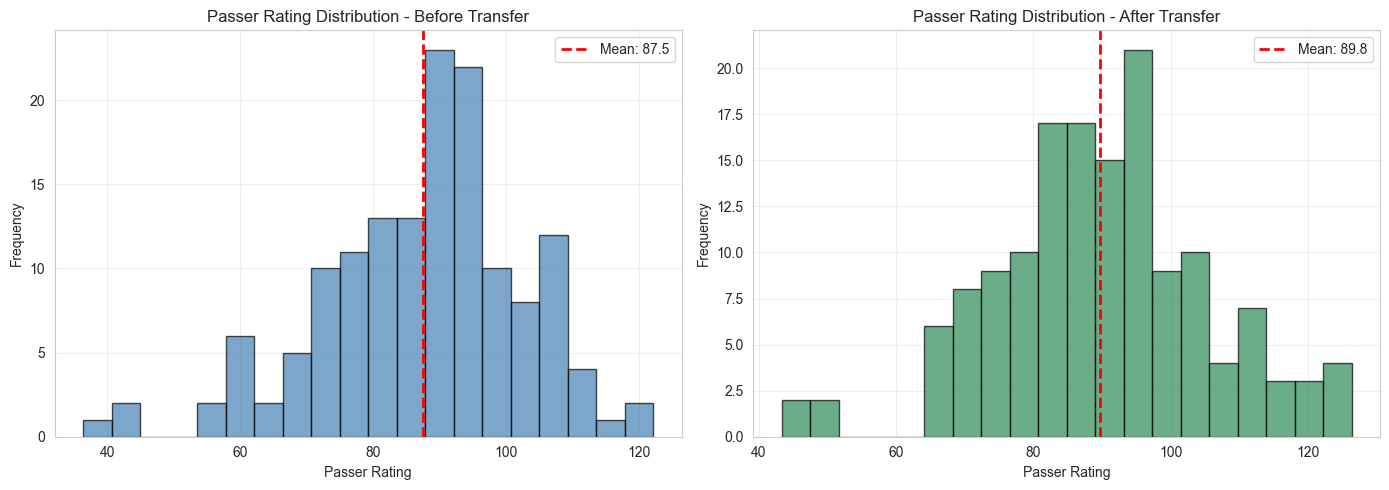

Mean passer rating before: 87.48
Mean passer rating after:  89.77
Median before: 89.98
Median after:  89.41


In [7]:
# Distribution of passer ratings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before transfer
axes[0].hist(roi_df['before_passer_rating'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(roi_df['before_passer_rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {roi_df["before_passer_rating"].mean():.1f}')
axes[0].set_xlabel('Passer Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Passer Rating Distribution - Before Transfer')
axes[0].legend()
axes[0].grid(alpha=0.3)

# After transfer
axes[1].hist(roi_df['after_passer_rating'], bins=20, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(roi_df['after_passer_rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {roi_df["after_passer_rating"].mean():.1f}')
axes[1].set_xlabel('Passer Rating')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Passer Rating Distribution - After Transfer')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean passer rating before: {roi_df['before_passer_rating'].mean():.2f}")
print(f"Mean passer rating after:  {roi_df['after_passer_rating'].mean():.2f}")
print(f"Median before: {roi_df['before_passer_rating'].median():.2f}")
print(f"Median after:  {roi_df['after_passer_rating'].median():.2f}")

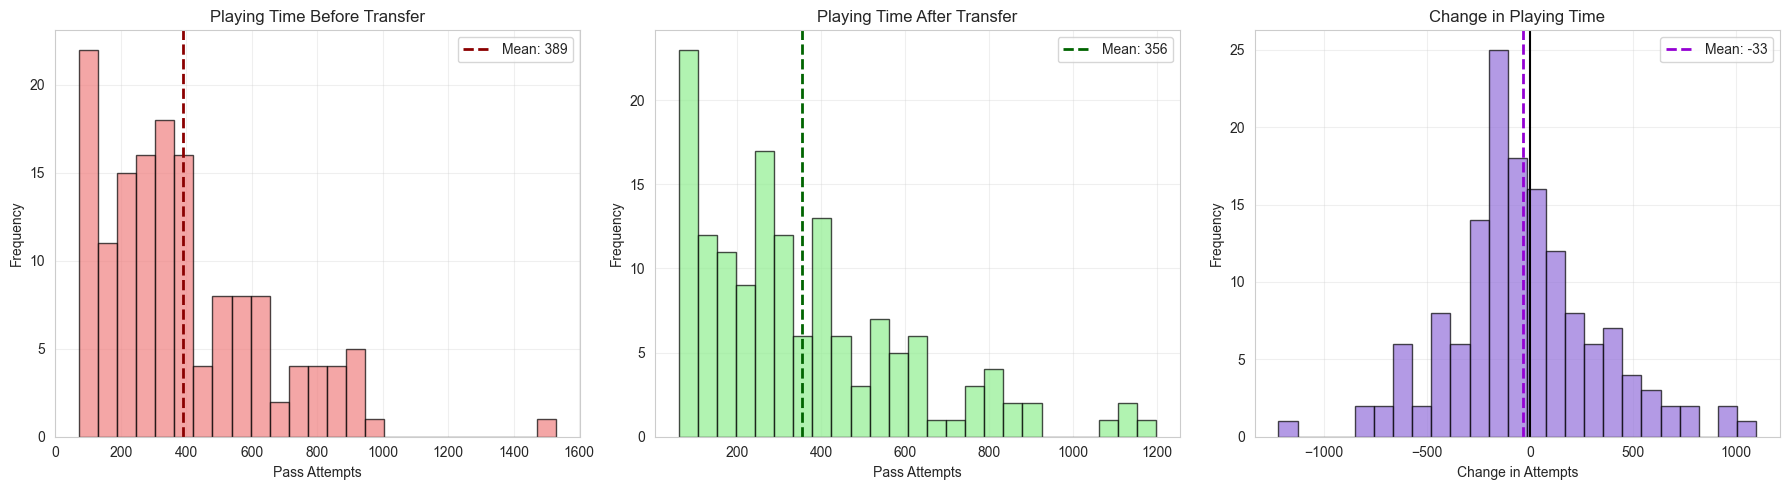

In [8]:
# Exploring attempts (playing time)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Before attempts
axes[0].hist(roi_df['before_attempts'], bins=25, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0].axvline(roi_df['before_attempts'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {roi_df["before_attempts"].mean():.0f}')
axes[0].set_xlabel('Pass Attempts')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Playing Time Before Transfer')
axes[0].legend()
axes[0].grid(alpha=0.3)

# After attempts
axes[1].hist(roi_df['after_attempts'], bins=25, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(roi_df['after_attempts'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {roi_df["after_attempts"].mean():.0f}')
axes[1].set_xlabel('Pass Attempts')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Playing Time After Transfer')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Change in attempts
axes[2].hist(roi_df['attempts_change'], bins=25, color='mediumpurple', alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='black', linestyle='-', linewidth=1.5)
axes[2].axvline(roi_df['attempts_change'].mean(), color='darkviolet', linestyle='--', linewidth=2, label=f'Mean: {roi_df["attempts_change"].mean():.0f}')
axes[2].set_xlabel('Change in Attempts')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Change in Playing Time')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

We can see that the distribution of passer ratings before and after transfers shows some shifts, with the mean change in playing time actually decreasing slightly. If we look at the distribution from before and after, we can see that the reason for this is that there are a significant number of QBs who hardly get any attemps after transferring.  This skews the distibution.  The post-transfer distribution has a smoother right tail, indicating that a lot of QBs do significantly improve their performance after transferring.

### Multi-Feature Relationships

Exploring relationships between multiple features to understand patterns.

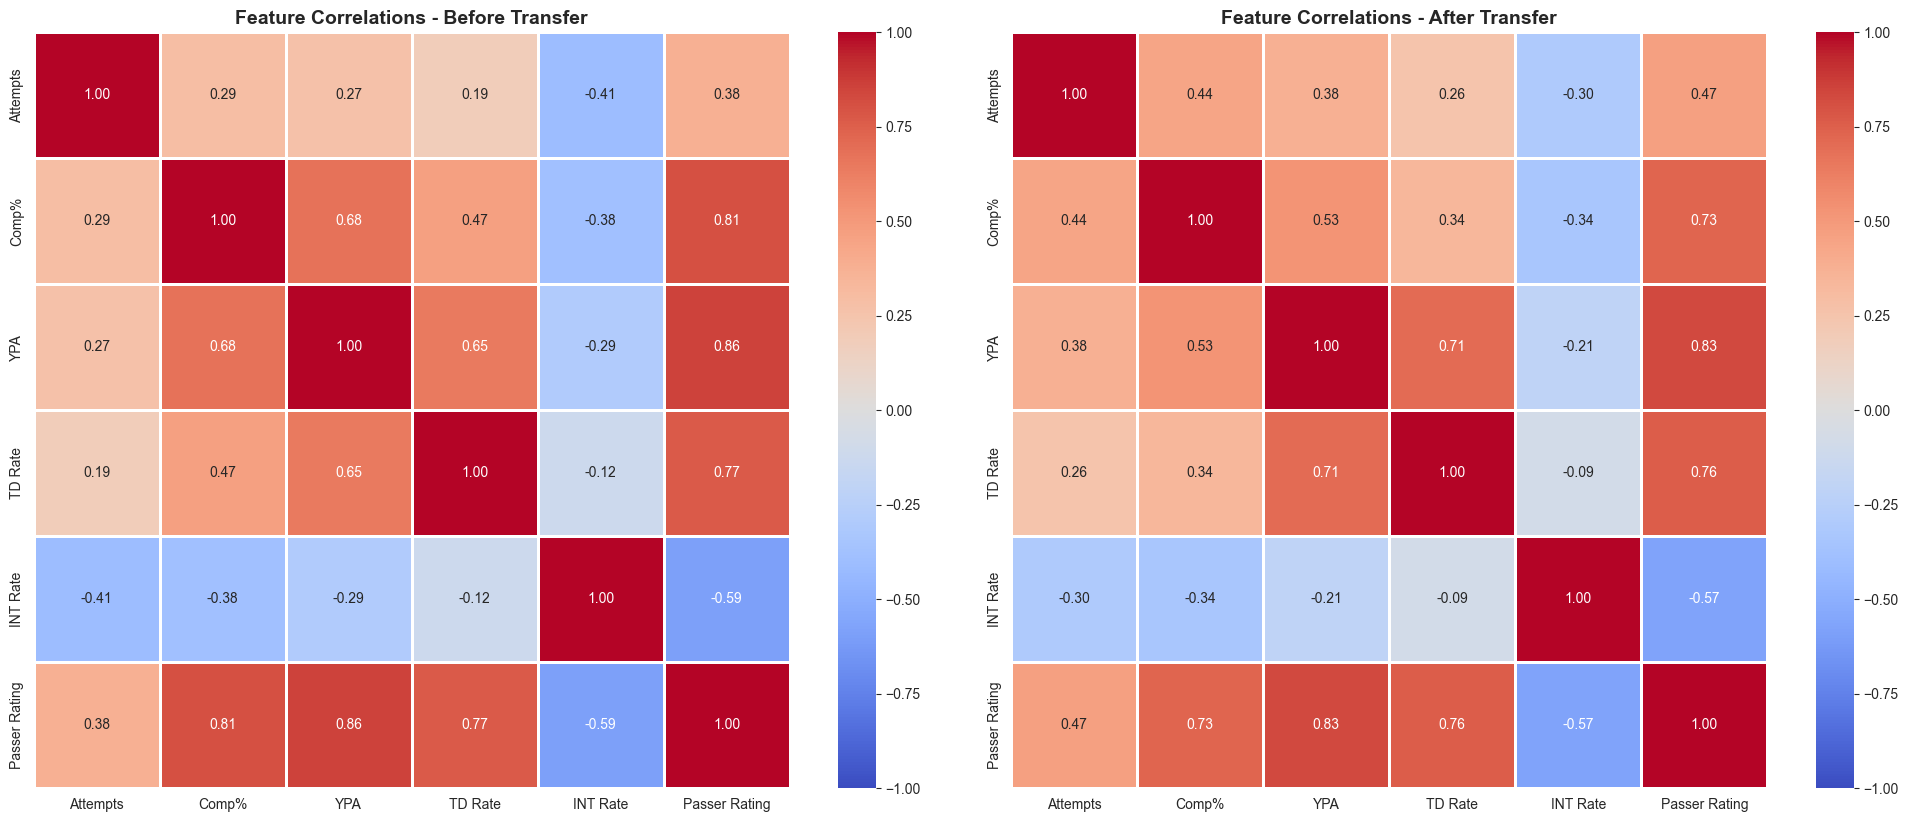

In [9]:
# correlation heatmap of key metrics before transfer
before_metrics = roi_df[['before_attempts', 'before_comp_pct', 'before_ypa',
                         'before_td_rate', 'before_int_rate', 'before_passer_rating']].copy()
before_metrics.columns = ['Attempts', 'Comp%', 'YPA', 'TD Rate', 'INT Rate', 'Passer Rating']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Before transfer
sns.heatmap(before_metrics.corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, linewidths=1, ax=axes[0])
axes[0].set_title('Feature Correlations - Before Transfer', fontsize=14, fontweight='bold')

# After transfer
after_metrics = roi_df[['after_attempts', 'after_comp_pct', 'after_ypa',
                        'after_td_rate', 'after_int_rate', 'after_passer_rating']].copy()
after_metrics.columns = ['Attempts', 'Comp%', 'YPA', 'TD Rate', 'INT Rate', 'Passer Rating']

sns.heatmap(after_metrics.corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, linewidths=1, ax=axes[1])
axes[1].set_title('Feature Correlations - After Transfer', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

These heatmaps are very similar, which is expected, it indicates that the metrics relate to each other in similar ways both before and after transfer.

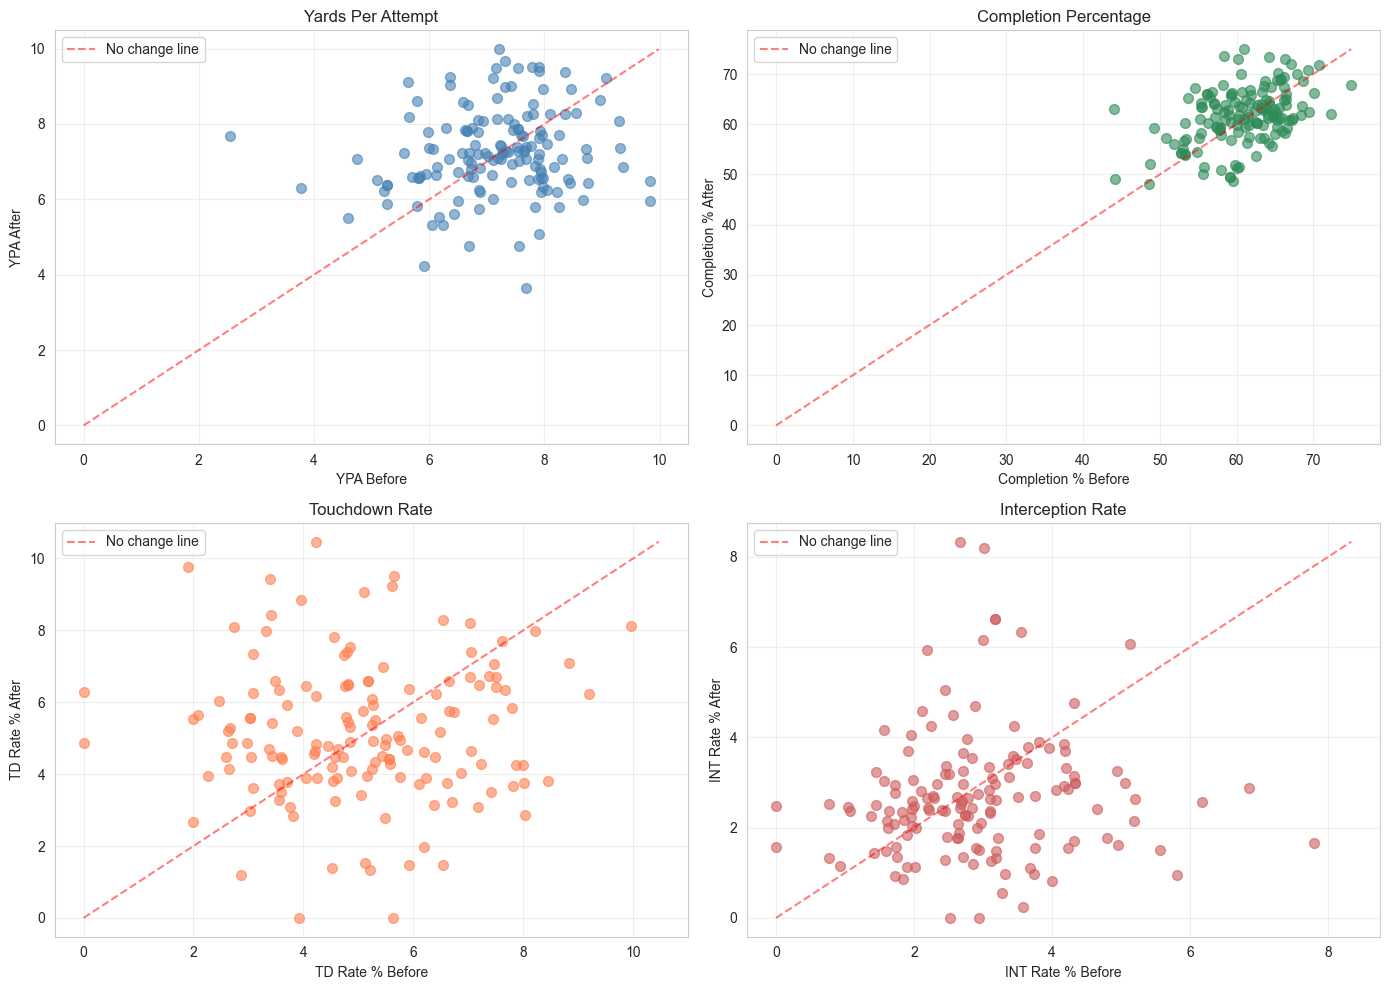

In [10]:
# multi-panel view of efficiency metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# YPA before vs after
axes[0, 0].scatter(roi_df['before_ypa'], roi_df['after_ypa'], alpha=0.6, s=50, c='steelblue')
max_ypa = max(roi_df['before_ypa'].max(), roi_df['after_ypa'].max())
axes[0, 0].plot([0, max_ypa], [0, max_ypa], 'r--', alpha=0.5, label='No change line')
axes[0, 0].set_xlabel('YPA Before')
axes[0, 0].set_ylabel('YPA After')
axes[0, 0].set_title('Yards Per Attempt')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Completion percentage
axes[0, 1].scatter(roi_df['before_comp_pct'], roi_df['after_comp_pct'], alpha=0.6, s=50, c='seagreen')
max_comp = max(roi_df['before_comp_pct'].max(), roi_df['after_comp_pct'].max())
axes[0, 1].plot([0, max_comp], [0, max_comp], 'r--', alpha=0.5, label='No change line')
axes[0, 1].set_xlabel('Completion % Before')
axes[0, 1].set_ylabel('Completion % After')
axes[0, 1].set_title('Completion Percentage')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TD Rate
axes[1, 0].scatter(roi_df['before_td_rate']*100, roi_df['after_td_rate']*100, alpha=0.6, s=50, c='coral')
max_td = max(roi_df['before_td_rate'].max(), roi_df['after_td_rate'].max()) * 100
axes[1, 0].plot([0, max_td], [0, max_td], 'r--', alpha=0.5, label='No change line')
axes[1, 0].set_xlabel('TD Rate % Before')
axes[1, 0].set_ylabel('TD Rate % After')
axes[1, 0].set_title('Touchdown Rate')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# INT Rate
axes[1, 1].scatter(roi_df['before_int_rate']*100, roi_df['after_int_rate']*100, alpha=0.6, s=50, c='indianred')
max_int = max(roi_df['before_int_rate'].max(), roi_df['after_int_rate'].max()) * 100
axes[1, 1].plot([0, max_int], [0, max_int], 'r--', alpha=0.5, label='No change line')
axes[1, 1].set_xlabel('INT Rate % Before')
axes[1, 1].set_ylabel('INT Rate % After')
axes[1, 1].set_title('Interception Rate')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Experiments with Different Plot Types

Trying visualization approaches to find the clearest ways to show my findings.

/var/folders/4z/hd4s19xs4hb8xy7pkxtdvxvr0000gp/T/ipykernel_68079/1332003979.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=passer_data, x='Timing', y='Passer Rating', ax=axes[0], palette='Set2')
/var/folders/4z/hd4s19xs4hb8xy7pkxtdvxvr0000gp/T/ipykernel_68079/1332003979.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ypa_data, x='Timing', y='YPA', ax=axes[1], palette='Set3')


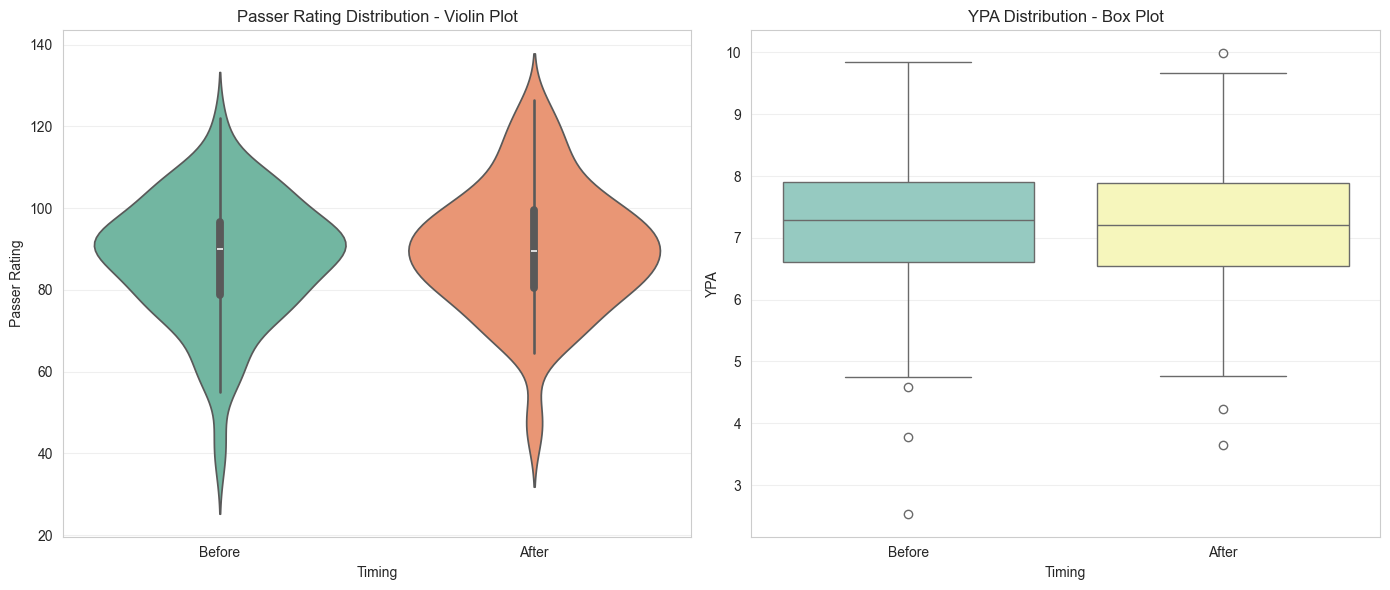

In [11]:
# Violin plots for comparing distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for violin plot
passer_data = pd.DataFrame({
    'Passer Rating': list(roi_df['before_passer_rating']) + list(roi_df['after_passer_rating']),
    'Timing': ['Before']*len(roi_df) + ['After']*len(roi_df)
})

ypa_data = pd.DataFrame({
    'YPA': list(roi_df['before_ypa']) + list(roi_df['after_ypa']),
    'Timing': ['Before']*len(roi_df) + ['After']*len(roi_df)
})

# Violin plot
sns.violinplot(data=passer_data, x='Timing', y='Passer Rating', ax=axes[0], palette='Set2')
axes[0].set_title('Passer Rating Distribution - Violin Plot')
axes[0].grid(axis='y', alpha=0.3)

# Box plot for comparison
sns.boxplot(data=ypa_data, x='Timing', y='YPA', ax=axes[1], palette='Set3')
axes[1].set_title('YPA Distribution - Box Plot')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Both distrubutions show very similar patterns, so they aren't very useful for distinguishing pre- and post-transfer performance.

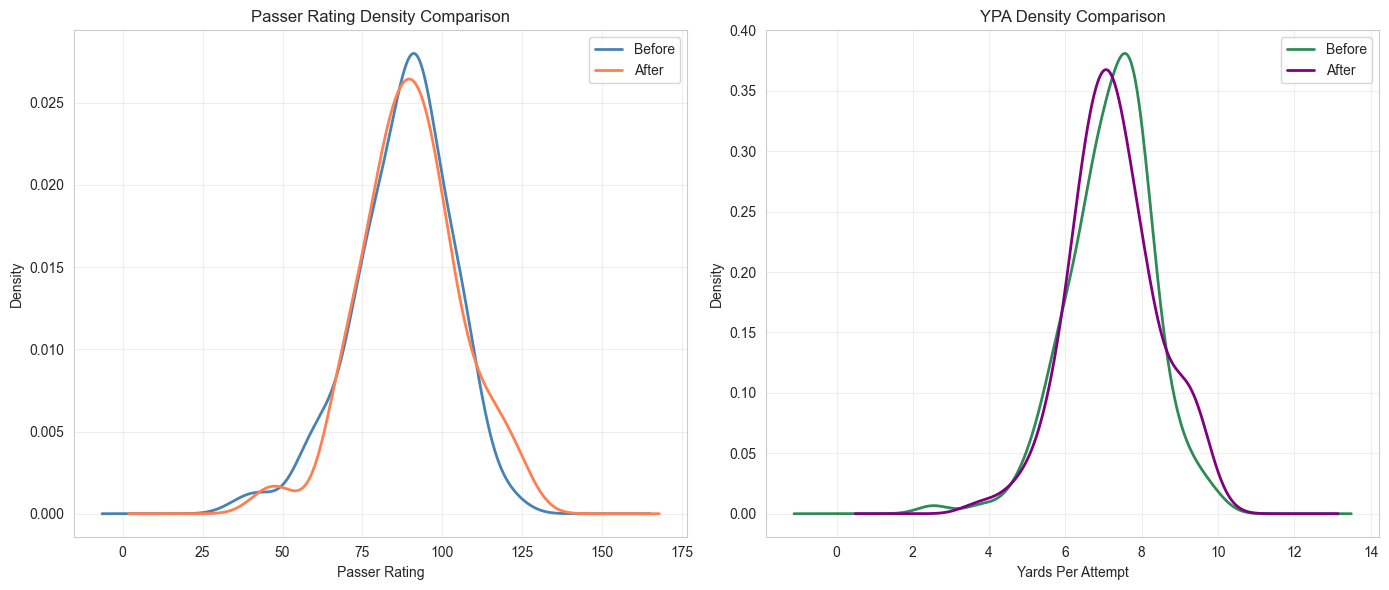

In [12]:
# Density plots (KDE)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Passer rating density
roi_df['before_passer_rating'].plot(kind='density', ax=axes[0], label='Before', color='steelblue', linewidth=2)
roi_df['after_passer_rating'].plot(kind='density', ax=axes[0], label='After', color='coral', linewidth=2)
axes[0].set_xlabel('Passer Rating')
axes[0].set_ylabel('Density')
axes[0].set_title('Passer Rating Density Comparison')
axes[0].legend()
axes[0].grid(alpha=0.3)

# YPA density
roi_df['before_ypa'].plot(kind='density', ax=axes[1], label='Before', color='seagreen', linewidth=2)
roi_df['after_ypa'].plot(kind='density', ax=axes[1], label='After', color='purple', linewidth=2)
axes[1].set_xlabel('Yards Per Attempt')
axes[1].set_ylabel('Density')
axes[1].set_title('YPA Density Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

This plot is very interesting, it shows that while the peak of both plots post-transfer is at a slightly lower passer rating/YPA, the right trail of both plots is longer post-transfer, indicating that a significant number of QBs perform very well after transferring.

## Summary Statistics

## Visualizations: Key Performance Metrics

In [13]:
def create_scatter_plot(ax, df, x_col, y_col, hue_col, title, improved_label="Improved"):
    improved_count = df[hue_col].sum()
    declined_count = len(df) - improved_count
    
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, s=100, alpha=0.7, ax=ax)
    
    max_val = max(df[x_col].max(), df[y_col].max())
    ax.plot([0, max_val], [0, max_val], "k--", alpha=0.3, label="No change")
    
    ax.set_title(f"{title}\n{improved_label}: {improved_count} | Declined: {declined_count}")
    ax.legend(title=improved_label)
    
    return ax

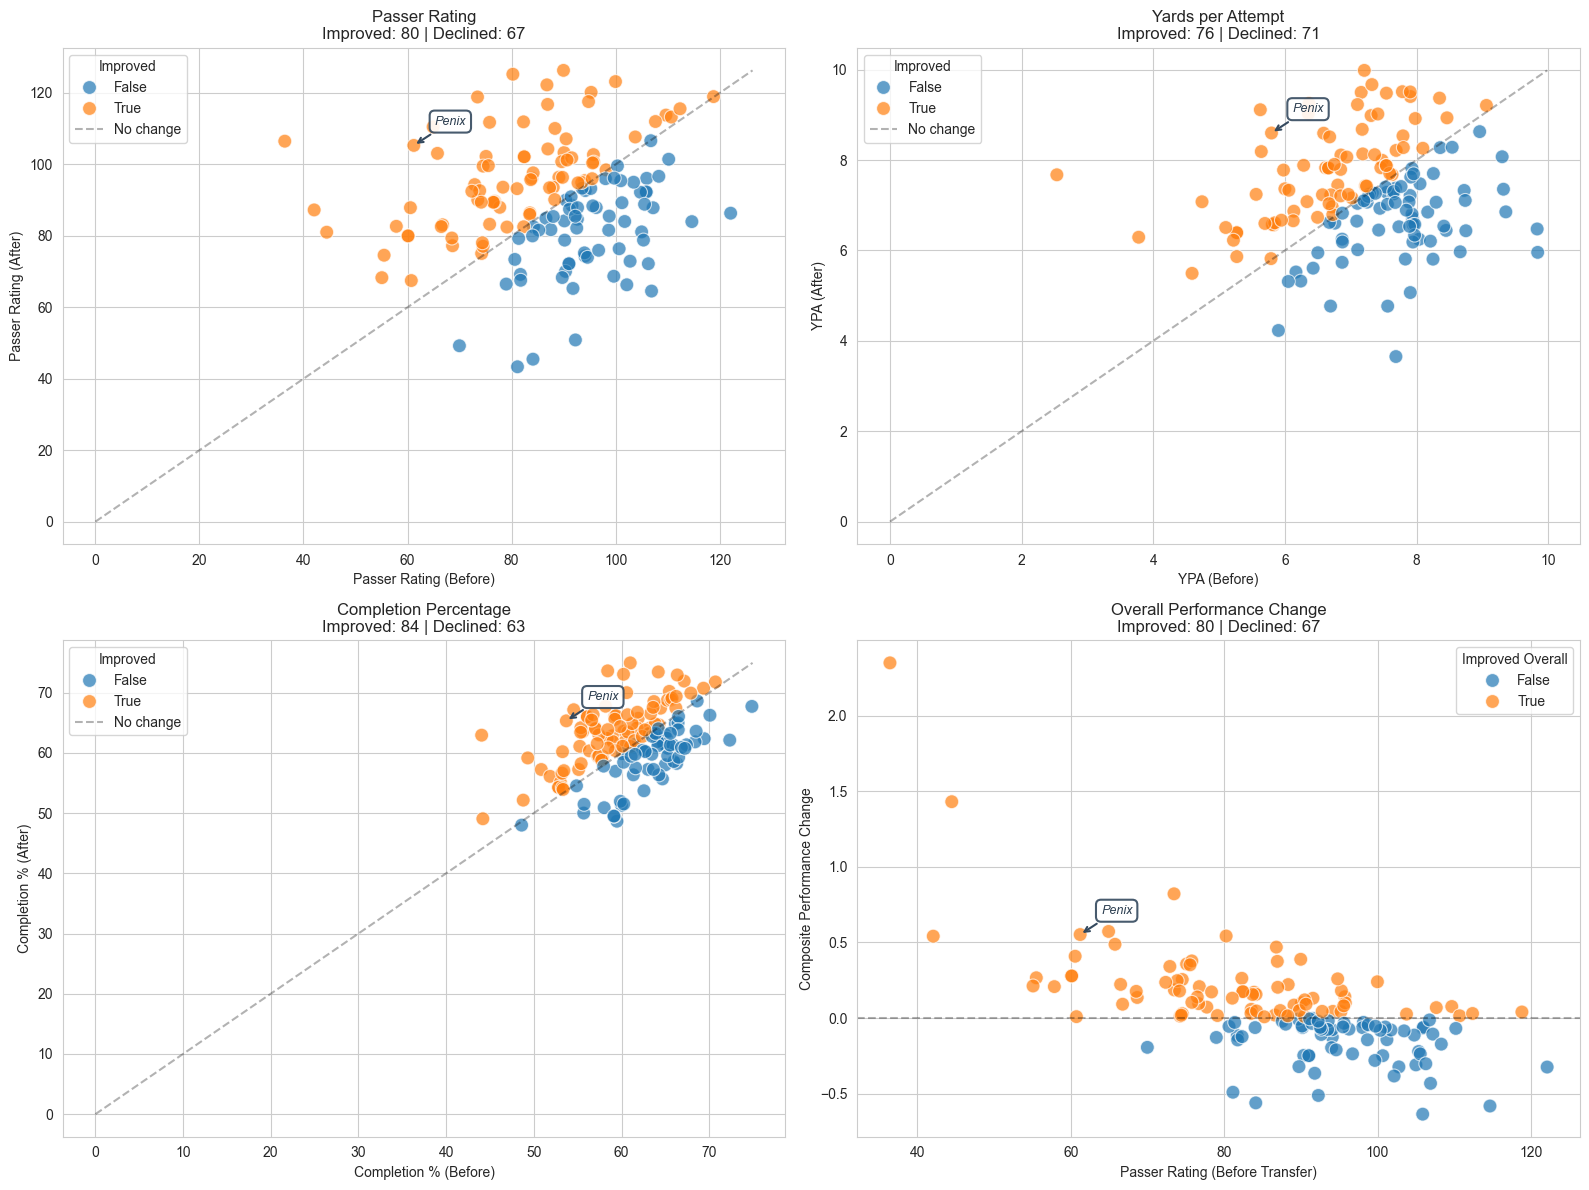

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

create_scatter_plot(
    axes[0, 0], roi_df, "before_passer_rating", "after_passer_rating", "passer_rating_improved",
    "Passer Rating", "Improved"
)
axes[0, 0].set_xlabel("Passer Rating (Before)")
axes[0, 0].set_ylabel("Passer Rating (After)")

penix = roi_df[roi_df["player"] == "Michael Penix Jr."]
if not penix.empty:
    axes[0, 0].annotate("Penix", 
                       xy=(penix.iloc[0]["before_passer_rating"], penix.iloc[0]["after_passer_rating"]),
                       xytext=(15, 15), textcoords="offset points",
                       fontsize=9, style='italic', color='#2c3e50',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="#34495e", linewidth=1.5, alpha=0.9),
                       arrowprops=dict(arrowstyle="->", color="#34495e", lw=1.5))

create_scatter_plot(
    axes[0, 1], roi_df, "before_ypa", "after_ypa", "ypa_improved",
    "Yards per Attempt", "Improved"
)
axes[0, 1].set_xlabel("YPA (Before)")
axes[0, 1].set_ylabel("YPA (After)")

if not penix.empty:
    axes[0, 1].annotate("Penix", 
                       xy=(penix.iloc[0]["before_ypa"], penix.iloc[0]["after_ypa"]),
                       xytext=(15, 15), textcoords="offset points",
                       fontsize=9, style='italic', color='#2c3e50',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="#34495e", linewidth=1.5, alpha=0.9),
                       arrowprops=dict(arrowstyle="->", color="#34495e", lw=1.5))

create_scatter_plot(
    axes[1, 0], roi_df, "before_comp_pct", "after_comp_pct", "comp_pct_improved",
    "Completion Percentage", "Improved"
)
axes[1, 0].set_xlabel("Completion % (Before)")
axes[1, 0].set_ylabel("Completion % (After)")

if not penix.empty:
    axes[1, 0].annotate("Penix", 
                       xy=(penix.iloc[0]["before_comp_pct"], penix.iloc[0]["after_comp_pct"]),
                       xytext=(15, 15), textcoords="offset points",
                       fontsize=9, style='italic', color='#2c3e50',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="#34495e", linewidth=1.5, alpha=0.9),
                       arrowprops=dict(arrowstyle="->", color="#34495e", lw=1.5))

composite_improved = roi_df["composite_score"] > 0
improved_count = composite_improved.sum()
declined_count = len(roi_df) - improved_count

sns.scatterplot(
    data=roi_df, x="before_passer_rating", y="composite_score",
    hue=composite_improved, s=100, alpha=0.7, ax=axes[1, 1]
)
axes[1, 1].axhline(y=0, color="k", linestyle="--", alpha=0.3)
axes[1, 1].set_xlabel("Passer Rating (Before Transfer)")
axes[1, 1].set_ylabel("Composite Performance Change")
axes[1, 1].set_title(f"Overall Performance Change\nImproved: {improved_count} | Declined: {declined_count}")
axes[1, 1].legend(title="Improved Overall")

if not penix.empty:
    axes[1, 1].annotate("Penix", 
                       xy=(penix.iloc[0]["before_passer_rating"], penix.iloc[0]["composite_score"]),
                       xytext=(15, 15), textcoords="offset points",
                       fontsize=9, style='italic', color='#2c3e50',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="#34495e", linewidth=1.5, alpha=0.9),
                       arrowprops=dict(arrowstyle="->", color="#34495e", lw=1.5))

plt.tight_layout()
plt.show()

## Volume Stats Analysis (QBs Who Played Most Games)
For Heisman consideration and public perception, total yards and TDs matter more than efficiency.
Analyzing QBs with 250+ attempts (roughly 10+ games, missing at most 2 games)

In [15]:
# Filter for QBs who played most games (250+ attempts = ~10+ games, missed at most 2)
volume_stats_mask = (roi_df["before_attempts"] >= 250) & (roi_df["after_attempts"] >= 250)
volume_stats_qbs = roi_df[volume_stats_mask].copy()

# Calculate volume stats
volume_stats_qbs = volume_stats_qbs.assign(
    before_pass_yds=volume_stats_qbs["before_ypa"] * volume_stats_qbs["before_attempts"],
    after_pass_yds=volume_stats_qbs["after_ypa"] * volume_stats_qbs["after_attempts"],
    before_pass_tds=volume_stats_qbs["before_td_rate"] * volume_stats_qbs["before_attempts"],
    after_pass_tds=volume_stats_qbs["after_td_rate"] * volume_stats_qbs["after_attempts"]
)

volume_stats_qbs = volume_stats_qbs.assign(
    pass_yds_change=volume_stats_qbs["after_pass_yds"] - volume_stats_qbs["before_pass_yds"],
    pass_tds_change=volume_stats_qbs["after_pass_tds"] - volume_stats_qbs["before_pass_tds"]
)

print(f"QBs with 250+ attempts before AND after (missed at most 2 games): {len(volume_stats_qbs)}")
print(f"\nVolume Stats Summary:")
print(f"  Avg passing yards before: {volume_stats_qbs['before_pass_yds'].mean():.0f}")
print(f"  Avg passing yards after:  {volume_stats_qbs['after_pass_yds'].mean():.0f}")
print(f"  Avg change:               {volume_stats_qbs['pass_yds_change'].mean():+.0f}")
print(f"\n  Avg passing TDs before:   {volume_stats_qbs['before_pass_tds'].mean():.1f}")
print(f"  Avg passing TDs after:    {volume_stats_qbs['after_pass_tds'].mean():.1f}")
print(f"  Avg change:               {volume_stats_qbs['pass_tds_change'].mean():+.1f}")
print(f"\n  Avg total TDs before:     {volume_stats_qbs['before_total_tds'].mean():.1f}")
print(f"  Avg total TDs after:      {volume_stats_qbs['after_total_tds'].mean():.1f}")
print(f"  Avg change:               {volume_stats_qbs['total_tds_change'].mean():+.1f}")

improved_yds = (volume_stats_qbs["pass_yds_change"] > 0).sum()
improved_tds = (volume_stats_qbs["pass_tds_change"] > 0).sum()
print(f"\n  QBs with MORE passing yards: {improved_yds}/{len(volume_stats_qbs)} ({100*improved_yds/len(volume_stats_qbs):.1f}%)")
print(f"  QBs with MORE passing TDs:   {improved_tds}/{len(volume_stats_qbs)} ({100*improved_tds/len(volume_stats_qbs):.1f}%)")

QBs with 250+ attempts before AND after (missed at most 2 games): 63

Volume Stats Summary:
  Avg passing yards before: 4083
  Avg passing yards after:  3558
  Avg change:               -525

  Avg passing TDs before:   29.2
  Avg passing TDs after:    26.0
  Avg change:               -3.1

  Avg total TDs before:     34.2
  Avg total TDs after:      31.2
  Avg change:               -3.0

  QBs with MORE passing yards: 24/63 (38.1%)
  QBs with MORE passing TDs:   26/63 (41.3%)


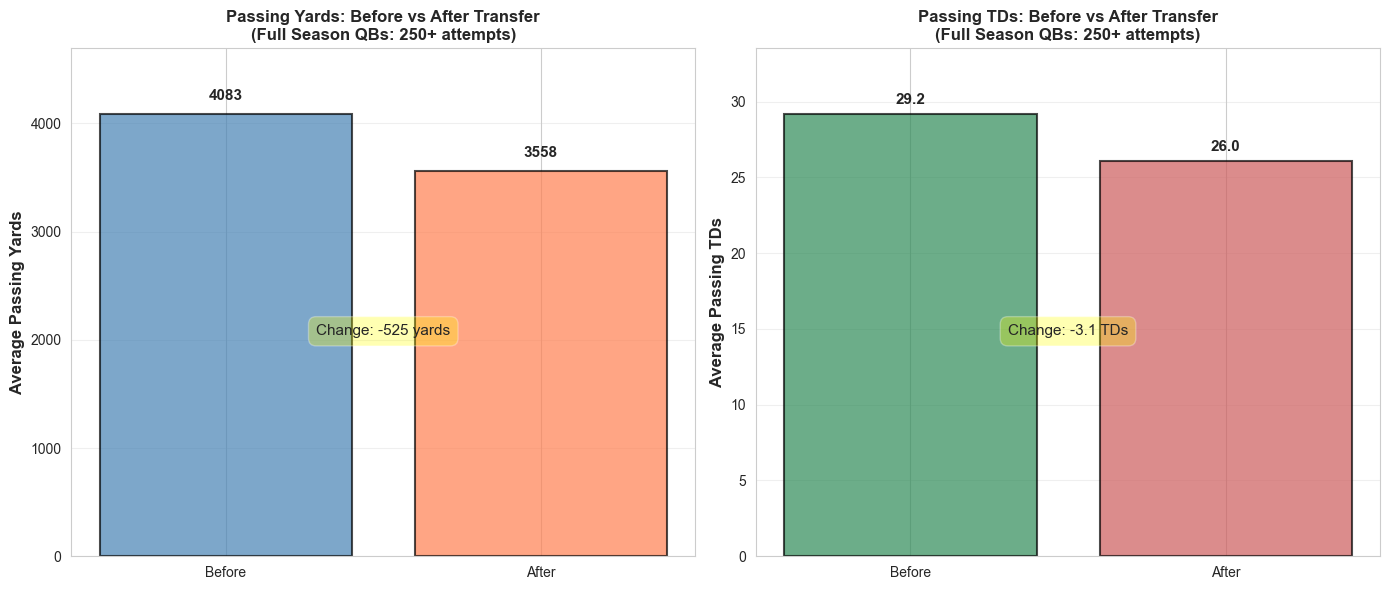


Key Insight: Even among full-season QBs (250+ attempts both years),
volume stats decline on average, suggesting reduced playing time or offensive opportunities.


In [16]:
# Visualize volume stats changes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Passing yards comparison
yards_data = ['Before', 'After']
yards_values = [volume_stats_qbs['before_pass_yds'].mean(), volume_stats_qbs['after_pass_yds'].mean()]
colors_yards = ['steelblue', 'coral']

bars1 = axes[0].bar(yards_data, yards_values, color=colors_yards, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Average Passing Yards', fontsize=12, fontweight='bold')
axes[0].set_title('Passing Yards: Before vs After Transfer\n(Full Season QBs: 250+ attempts)', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(yards_values) * 1.15)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars1, yards_values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 100,
                f'{val:.0f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add change annotation
change_yds = yards_values[1] - yards_values[0]
axes[0].text(0.5, max(yards_values) * 0.5, f'Change: {change_yds:+.0f} yards',
            ha='center', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

# Passing TDs comparison
tds_data = ['Before', 'After']
tds_values = [volume_stats_qbs['before_pass_tds'].mean(), volume_stats_qbs['after_pass_tds'].mean()]
colors_tds = ['seagreen', 'indianred']

bars2 = axes[1].bar(tds_data, tds_values, color=colors_tds, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Average Passing TDs', fontsize=12, fontweight='bold')
axes[1].set_title('Passing TDs: Before vs After Transfer\n(Full Season QBs: 250+ attempts)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, max(tds_values) * 1.15)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars2, tds_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{val:.1f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add change annotation
change_tds = tds_values[1] - tds_values[0]
axes[1].text(0.5, max(tds_values) * 0.5, f'Change: {change_tds:+.1f} TDs',
            ha='center', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

print(f"\nKey Insight: Even among full-season QBs (250+ attempts both years),")
print(f"volume stats decline on average, suggesting reduced playing time or offensive opportunities.")

## Team Quality Analysis

**SP+ Rating**: Bill Connelly's opponent-adjusted team efficiency metric. A rating of 0 = average FBS team. Higher ratings = better teams. Each 5-point difference roughly translates to a 3-4 point game spread advantage.

## Team Quality Analysis
Analyzing whether stat changes are confounded by strength of schedule / opponent difficulty

In [17]:
from src.loaders import load_sp_plus_multi, load_team_records

sp_plus = load_sp_plus_multi(START_YEAR, END_YEAR)

print(f"Loaded SP+ ratings: {sp_plus.shape}")
print(f"Columns: {list(sp_plus.columns[:10])}")
sp_plus.head()

Loaded SP+ ratings: (532, 29)
Columns: ['year', 'team', 'conference', 'rating', 'ranking', 'secondOrderWins', 'sos', 'offense.ranking', 'offense.rating', 'offense.success']


,year,team,conference,rating,ranking,secondOrderWins,sos,offense.ranking,offense.rating,offense.success,...,defense.success,defense.explosiveness,defense.rushing,defense.passing,defense.standardDowns,defense.passingDowns,defense.havoc.total,defense.havoc.frontSeven,defense.havoc.db,specialTeams.rating
0,2021,Georgia,SEC,32.0,1.0,NaN,NaN,2.0,41.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,Ohio State,Big Ten,29.3,2.0,NaN,NaN,1.0,47.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,Alabama,SEC,26.0,3.0,NaN,NaN,4.0,40.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,Michigan,Big Ten,23.4,4.0,NaN,NaN,19.0,36.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,Cincinnati,Big 12,21.2,5.0,NaN,NaN,13.0,37.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
roi_with_team_quality = roi_df.copy()

roi_with_team_quality = roi_with_team_quality.merge(
    sp_plus[["year", "team", "rating", "sos", "offense.rating", "defense.rating"]],
    left_on=["transfer_season", "origin"],
    right_on=["year", "team"],
    how="left",
    suffixes=("", "_origin")
).drop(columns=["year", "team"])

roi_with_team_quality = roi_with_team_quality.rename(columns={
    "rating": "origin_sp_rating",
    "sos": "origin_sos",
    "offense.rating": "origin_offense",
    "defense.rating": "origin_defense"
})

roi_with_team_quality = roi_with_team_quality.merge(
    sp_plus[["year", "team", "rating", "sos", "offense.rating", "defense.rating"]],
    left_on=["transfer_season", "destination"],
    right_on=["year", "team"],
    how="left",
    suffixes=("", "_dest")
).drop(columns=["year", "team"])

roi_with_team_quality = roi_with_team_quality.rename(columns={
    "rating": "dest_sp_rating",
    "sos": "dest_sos",
    "offense.rating": "dest_offense",
    "defense.rating": "dest_defense"
})

roi_with_team_quality["sp_rating_change"] = roi_with_team_quality["dest_sp_rating"] - roi_with_team_quality["origin_sp_rating"]
roi_with_team_quality["sos_change"] = roi_with_team_quality["dest_sos"] - roi_with_team_quality["origin_sos"]

roi_with_team_quality["transfer_direction"] = "Lateral"
roi_with_team_quality.loc[roi_with_team_quality["sp_rating_change"] > 5, "transfer_direction"] = "Transfer UP"
roi_with_team_quality.loc[roi_with_team_quality["sp_rating_change"] < -5, "transfer_direction"] = "Transfer DOWN"

print(f"\nQBs with team quality data: {roi_with_team_quality[~roi_with_team_quality['origin_sp_rating'].isna()].shape[0]}")
print(f"\nTransfer direction breakdown:")
print(roi_with_team_quality["transfer_direction"].value_counts())

roi_with_team_quality[["player", "origin", "destination", "origin_sp_rating", "dest_sp_rating", "sp_rating_change", "transfer_direction"]].head(10)


QBs with team quality data: 136

Transfer direction breakdown:
transfer_direction
Lateral          61
Transfer DOWN    46
Transfer UP      40
Name: count, dtype: int64


,player,origin,destination,origin_sp_rating,dest_sp_rating,sp_rating_change,transfer_direction
0,Steven Krajewski,UConn,Georgia State,-14.6,-3.3,11.3,Transfer UP
1,Jordan Yates,Georgia Tech,Sam Houston,-11.8,NaN,NaN,Lateral
2,JT Daniels,Georgia,West Virginia,35.3,2.4,-32.9,Transfer DOWN
3,Emory Jones,Florida,Arizona State,10.4,-4.1,-14.5,Transfer DOWN
4,Jayden Daniels,Arizona State,LSU,-4.1,16.2,20.3,Transfer UP
5,Jaxson Dart,USC,Ole Miss,18.9,16.2,-2.7,Lateral
6,Jack Zergiotis,UConn,Merrimack,-14.6,NaN,NaN,Lateral
7,Aaron Allen,Louisiana Tech,Alcorn State,-17.8,NaN,NaN,Lateral
8,Sean Chambers,Wyoming,Montana State,-10.8,NaN,NaN,Lateral
9,Braxton Burmeister,Virginia Tech,San Diego State,-9.5,-4.4,5.1,Transfer UP


### Transfer Direction Classification

**Transfer UP**: Destination team is 5+ SP+ points better than origin  
**Lateral**: SP+ change within ±5 points (similar team quality)  
**Transfer DOWN**: Destination team is 5+ SP+ points worse than origin

In [19]:
print("="*80)
print("PERFORMANCE BY TRANSFER DIRECTION")
print("="*80)

valid_data = roi_with_team_quality[~roi_with_team_quality["origin_sp_rating"].isna()]

for direction in ["Transfer UP", "Lateral", "Transfer DOWN"]:
    subset = valid_data[valid_data["transfer_direction"] == direction]
    
    if len(subset) == 0:
        continue
    
    print(f"\n{direction} (n={len(subset)})")
    print("-"*60)
    print(f"  Avg Passer Rating change: {subset['passer_rating_change'].mean():+.2f}")
    print(f"  Avg YPA change:           {subset['ypa_change'].mean():+.3f}")
    print(f"  Avg Comp% change:         {subset['comp_pct_change'].mean():+.2f}%")
    print(f"  Avg TD rate change:       {subset['td_rate_change'].mean()*100:+.3f}%")
    print(f"  Positive Passer Rating ROI: {(subset['positive_passer_rating_roi'].sum() / len(subset) * 100):.1f}% (improved passer rating)")
    print(f"  Avg SP+ rating change:    {subset['sp_rating_change'].mean():+.2f}")

PERFORMANCE BY TRANSFER DIRECTION

Transfer UP (n=40)
------------------------------------------------------------
  Avg Passer Rating change: +6.72
  Avg YPA change:           +0.214
  Avg Comp% change:         +2.72%
  Avg TD rate change:       +0.767%
  Positive Passer Rating ROI: 62.5% (improved passer rating)
  Avg SP+ rating change:    +15.39

Lateral (n=50)
------------------------------------------------------------
  Avg Passer Rating change: +5.01
  Avg YPA change:           +0.182
  Avg Comp% change:         +0.88%
  Avg TD rate change:       +0.098%
  Positive Passer Rating ROI: 58.0% (improved passer rating)
  Avg SP+ rating change:    -0.06

Transfer DOWN (n=46)
------------------------------------------------------------
  Avg Passer Rating change: -3.92
  Avg YPA change:           -0.210
  Avg Comp% change:         -0.07%
  Avg TD rate change:       -0.468%
  Positive Passer Rating ROI: 43.5% (improved passer rating)
  Avg SP+ rating change:    -16.61


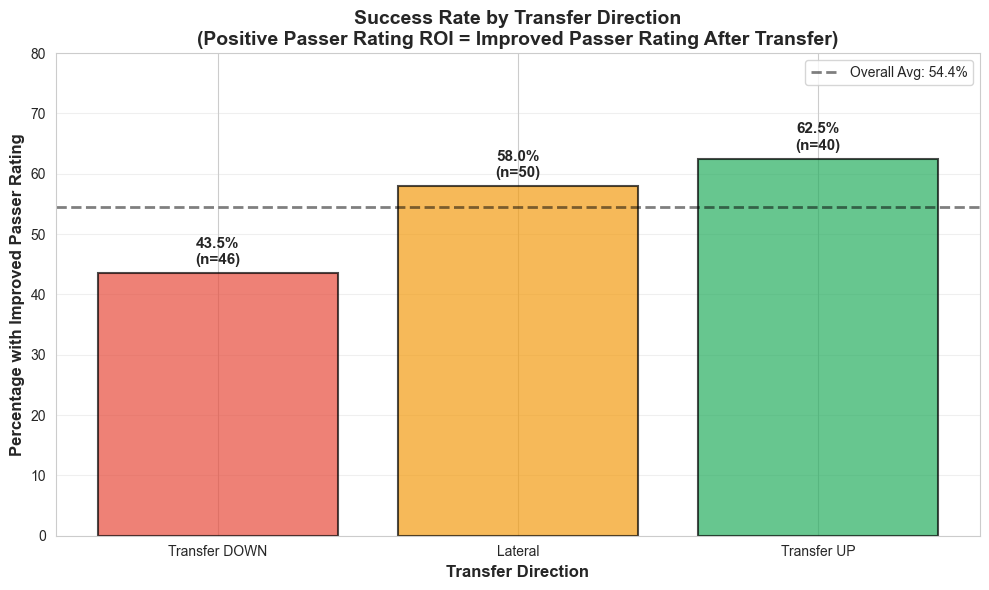


Overall: 54.4% of QBs improved their passer rating after transfer
Range: 43.5% (Transfer DOWN) to 62.5% (Transfer UP)
Difference: 19.0 percentage points


In [20]:
# Bar plot showing Positive Passer Rating ROI by Transfer Direction
valid_data = roi_with_team_quality[~roi_with_team_quality["origin_sp_rating"].isna()]

# Calculate percentages for each direction
directions = ['Transfer DOWN', 'Lateral', 'Transfer UP']
roi_percentages = []
n_counts = []

for direction in directions:
    subset = valid_data[valid_data["transfer_direction"] == direction]
    if len(subset) > 0:
        pct = (subset['positive_passer_rating_roi'].sum() / len(subset)) * 100
        roi_percentages.append(pct)
        n_counts.append(len(subset))
    else:
        roi_percentages.append(0)
        n_counts.append(0)

# Calculate overall average
overall_avg = (valid_data['positive_passer_rating_roi'].sum() / len(valid_data)) * 100

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c', '#f39c12', '#27ae60']  # Red, Orange, Green

bars = ax.bar(directions, roi_percentages, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i, (bar, pct, n) in enumerate(zip(bars, roi_percentages, n_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.1f}%\n(n={n})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add reference line at overall average
ax.axhline(y=overall_avg, color='black', linestyle='--', linewidth=2, alpha=0.5, 
           label=f'Overall Avg: {overall_avg:.1f}%')

ax.set_ylabel('Percentage with Improved Passer Rating', fontsize=12, fontweight='bold')
ax.set_xlabel('Transfer Direction', fontsize=12, fontweight='bold')
ax.set_title('Success Rate by Transfer Direction\n(Positive Passer Rating ROI = Improved Passer Rating After Transfer)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 80)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverall: {overall_avg:.1f}% of QBs improved their passer rating after transfer")
print(f"Range: {min(roi_percentages):.1f}% (Transfer DOWN) to {max(roi_percentages):.1f}% (Transfer UP)")
print(f"Difference: {max(roi_percentages) - min(roi_percentages):.1f} percentage points")

In [21]:
print("CORRELATION: Team Quality Change vs Performance Change")

valid_data = roi_with_team_quality[~roi_with_team_quality["origin_sp_rating"].isna()]

correlations = {
    "SP+ Rating Change": valid_data[["sp_rating_change", "passer_rating_change", "ypa_change", "comp_pct_change", "td_rate_change"]].corr()["sp_rating_change"]
}

print("\nCorrelations:")
print("\nSP+ Rating Change (higher = transferring to better team):")
for metric in ["passer_rating_change", "ypa_change", "comp_pct_change", "td_rate_change"]:
    corr = correlations["SP+ Rating Change"][metric]
    print(f"  {metric:25s}: {corr:+.3f}")

CORRELATION: Team Quality Change vs Performance Change

Correlations:

SP+ Rating Change (higher = transferring to better team):
  passer_rating_change     : +0.287
  ypa_change               : +0.159
  comp_pct_change          : +0.244
  td_rate_change           : +0.270


Note: Values close to 0 = no correlation, +1 = perfect positive, -1 = perfect negative

Here we can see that there is a slightly positive correlation, meaning that QBs transferring to better teams tend to perform better, and vice versa.

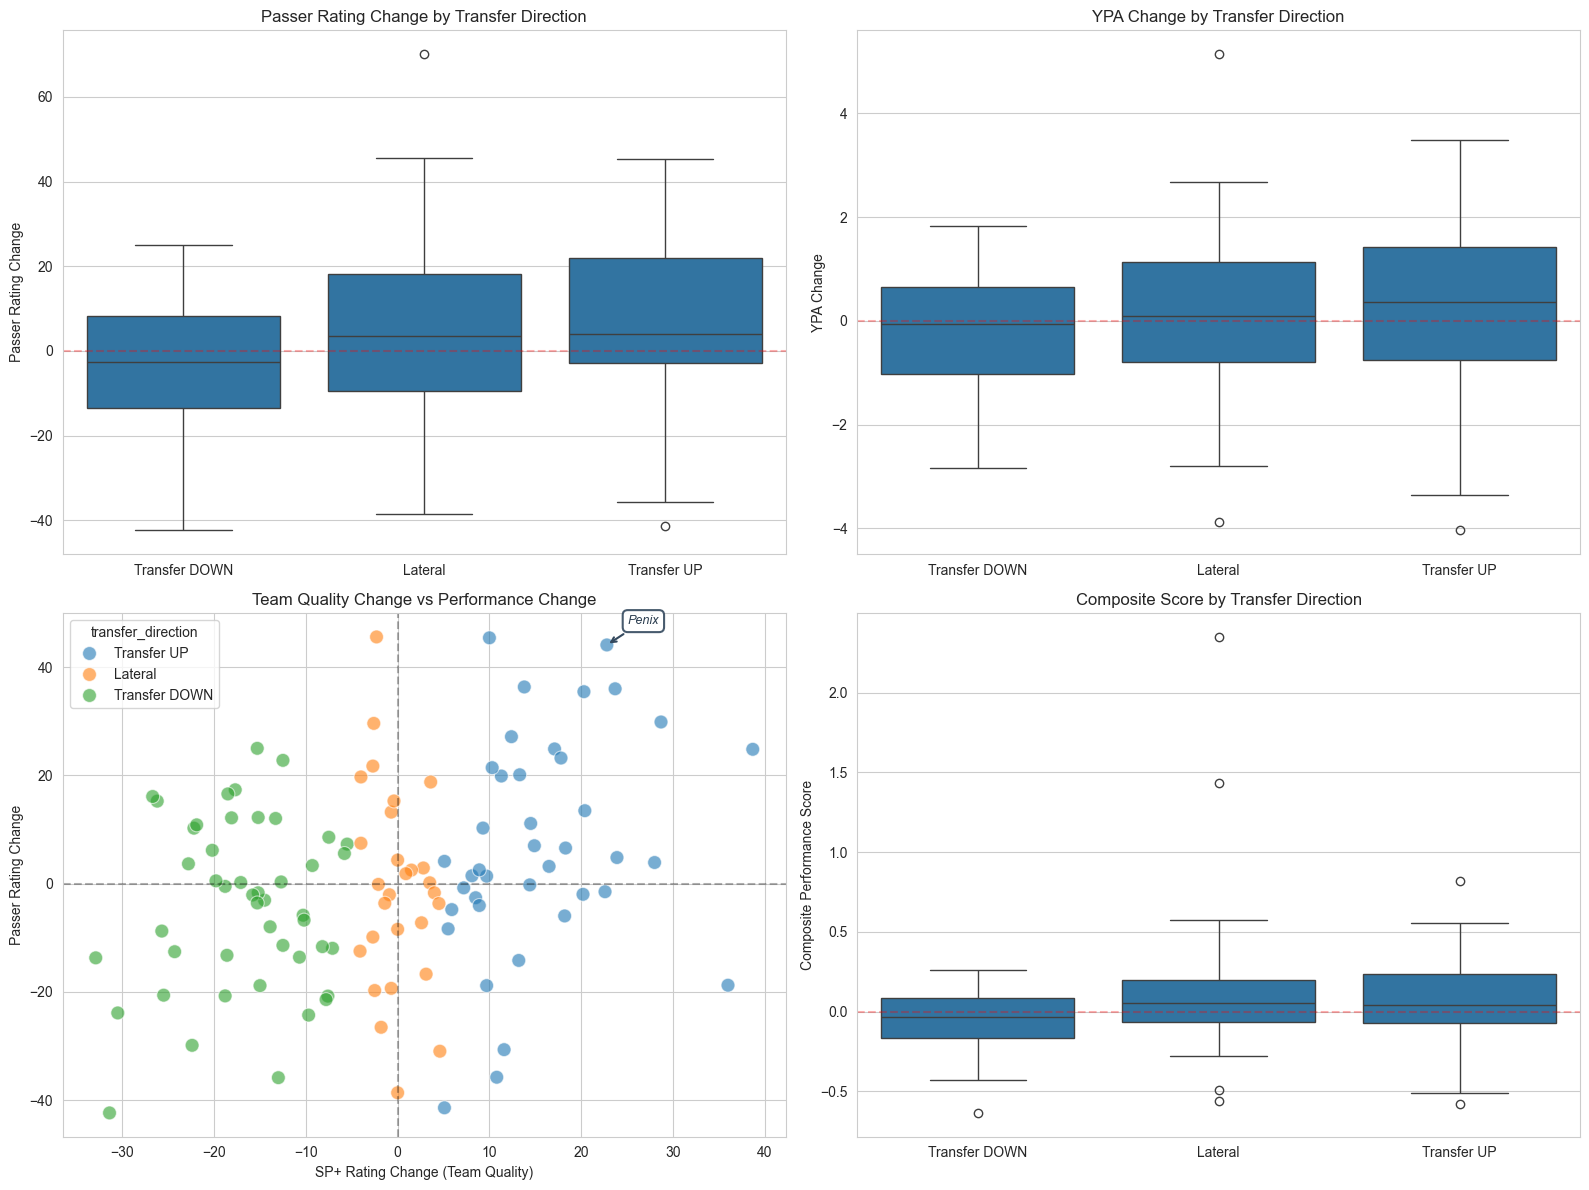

In [22]:
valid_data = roi_with_team_quality[~roi_with_team_quality["origin_sp_rating"].isna()]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(data=valid_data, x="transfer_direction", y="passer_rating_change", 
            order=["Transfer DOWN", "Lateral", "Transfer UP"], ax=axes[0, 0])
axes[0, 0].axhline(y=0, color="red", linestyle="--", alpha=0.3)
axes[0, 0].set_title("Passer Rating Change by Transfer Direction")
axes[0, 0].set_ylabel("Passer Rating Change")
axes[0, 0].set_xlabel("")

sns.boxplot(data=valid_data, x="transfer_direction", y="ypa_change",
            order=["Transfer DOWN", "Lateral", "Transfer UP"], ax=axes[0, 1])
axes[0, 1].axhline(y=0, color="red", linestyle="--", alpha=0.3)
axes[0, 1].set_title("YPA Change by Transfer Direction")
axes[0, 1].set_ylabel("YPA Change")
axes[0, 1].set_xlabel("")

sns.scatterplot(data=valid_data, x="sp_rating_change", y="passer_rating_change", 
                hue="transfer_direction", s=100, alpha=0.6, ax=axes[1, 0])
axes[1, 0].axhline(y=0, color="black", linestyle="--", alpha=0.3)
axes[1, 0].axvline(x=0, color="black", linestyle="--", alpha=0.3)
axes[1, 0].set_xlabel("SP+ Rating Change (Team Quality)")
axes[1, 0].set_ylabel("Passer Rating Change")
axes[1, 0].set_title("Team Quality Change vs Performance Change")

penix = valid_data[valid_data["player"] == "Michael Penix Jr."]
if not penix.empty:
    axes[1, 0].annotate("Penix", 
                       xy=(penix.iloc[0]["sp_rating_change"], penix.iloc[0]["passer_rating_change"]),
                       xytext=(15, 15), textcoords="offset points",
                       fontsize=9, style='italic', color='#2c3e50',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="#34495e", linewidth=1.5, alpha=0.9),
                       arrowprops=dict(arrowstyle="->", color="#34495e", lw=1.5))

sns.boxplot(data=valid_data, x="transfer_direction", y="composite_score",
            order=["Transfer DOWN", "Lateral", "Transfer UP"], ax=axes[1, 1])
axes[1, 1].axhline(y=0, color="red", linestyle="--", alpha=0.3)
axes[1, 1].set_title("Composite Score by Transfer Direction")
axes[1, 1].set_ylabel("Composite Performance Score")
axes[1, 1].set_xlabel("")

plt.tight_layout()
plt.show()

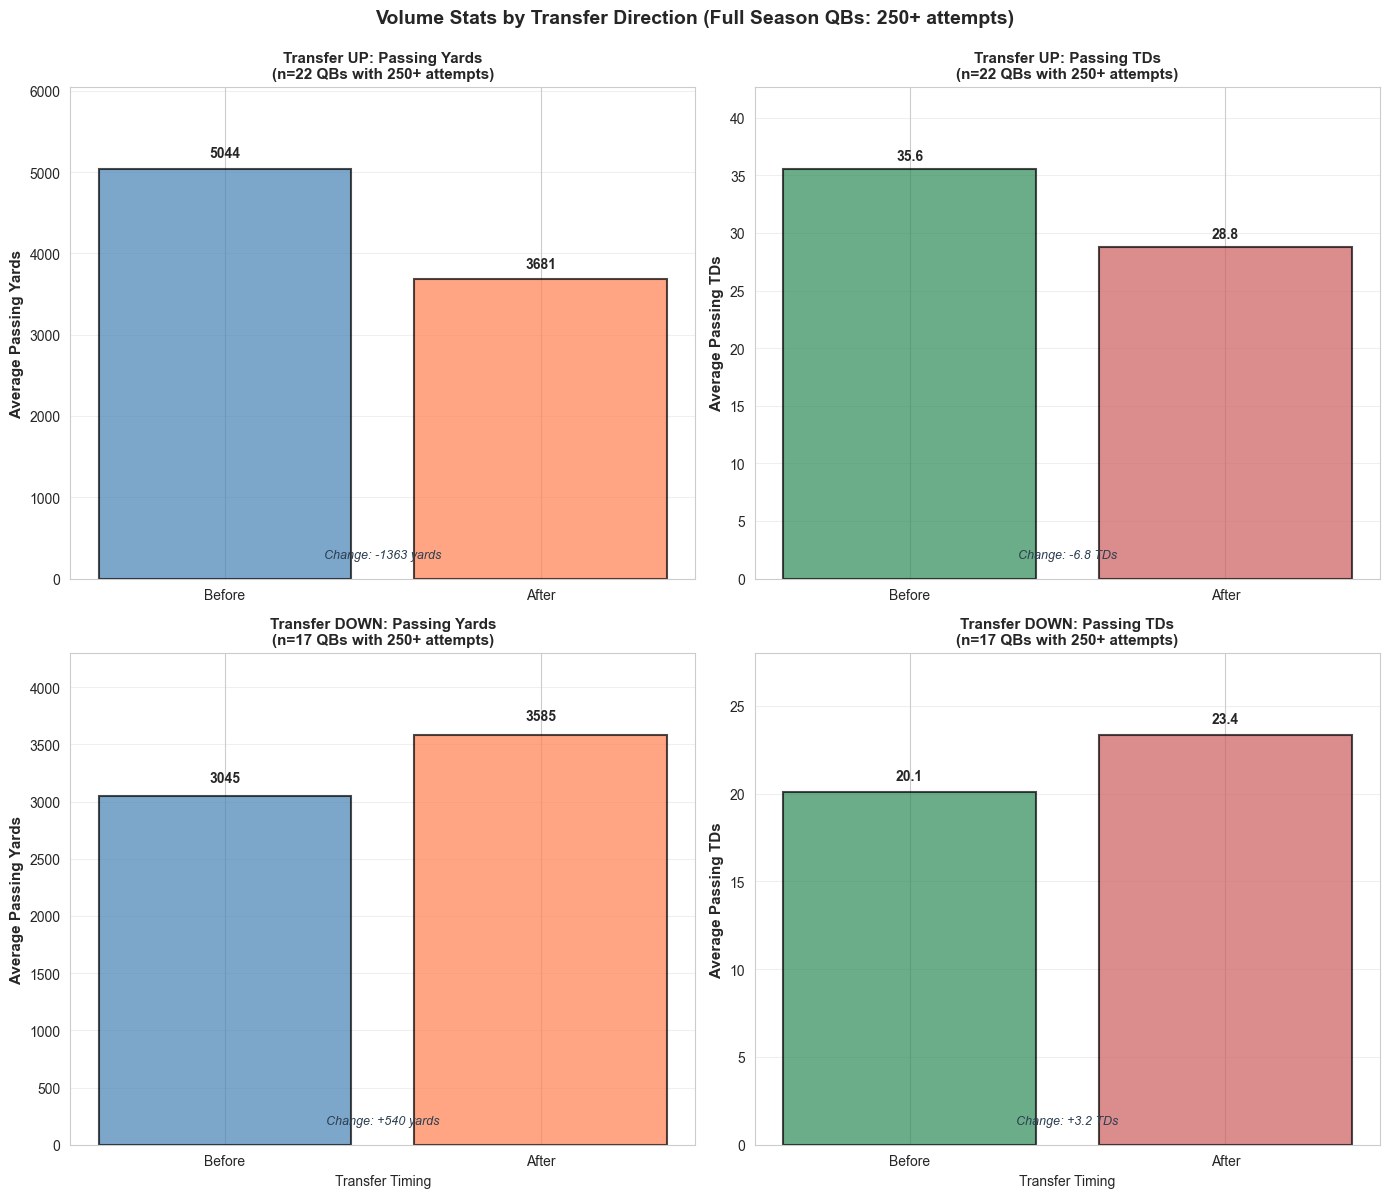


Key Findings:
  Transfer UP (n=22): Even when moving to better teams, volume stats decline.
  Transfer DOWN (n=17): QBs moving to worse teams also see volume declines.

This suggests volume declines are common regardless of transfer direction,
likely due to better teams having balanced offenses or QBs not being 'the guy' immediately.


In [23]:
# Volume stats by transfer direction (UP vs DOWN)
# Merge volume_stats_qbs with team quality data to get transfer direction
volume_with_direction = volume_stats_qbs.merge(
    roi_with_team_quality[['player', 'transfer_season', 'transfer_direction']],
    on=['player', 'transfer_season'],
    how='left'
)

# Filter for Transfer UP and DOWN
volume_transfer_up = volume_with_direction[volume_with_direction['transfer_direction'] == 'Transfer UP']
volume_transfer_down = volume_with_direction[volume_with_direction['transfer_direction'] == 'Transfer DOWN']

if len(volume_transfer_up) > 0 or len(volume_transfer_down) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # ===== TRANSFER UP (TOP ROW) =====
    if len(volume_transfer_up) > 0:
        # Passing yards - Transfer UP
        yards_data = ['Before', 'After']
        yards_values_up = [volume_transfer_up['before_pass_yds'].mean(), volume_transfer_up['after_pass_yds'].mean()]
        colors_yards = ['steelblue', 'coral']
        
        bars1 = axes[0, 0].bar(yards_data, yards_values_up, color=colors_yards, alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[0, 0].set_ylabel('Average Passing Yards', fontsize=11, fontweight='bold')
        axes[0, 0].set_title(f'Transfer UP: Passing Yards\n(n={len(volume_transfer_up)} QBs with 250+ attempts)', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylim(0, max(yards_values_up) * 1.2)
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars1, yards_values_up):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 100,
                        f'{val:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        change_yds_up = yards_values_up[1] - yards_values_up[0]
        axes[0, 0].text(0.5, max(yards_values_up) * 0.05, f'Change: {change_yds_up:+.0f} yards',
                    ha='center', fontsize=9, style='italic', color='#2c3e50')
        
        # Passing TDs - Transfer UP
        tds_values_up = [volume_transfer_up['before_pass_tds'].mean(), volume_transfer_up['after_pass_tds'].mean()]
        colors_tds = ['seagreen', 'indianred']
        
        bars2 = axes[0, 1].bar(yards_data, tds_values_up, color=colors_tds, alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[0, 1].set_ylabel('Average Passing TDs', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Transfer UP: Passing TDs\n(n={len(volume_transfer_up)} QBs with 250+ attempts)', fontsize=11, fontweight='bold')
        axes[0, 1].set_ylim(0, max(tds_values_up) * 1.2)
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars2, tds_values_up):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        change_tds_up = tds_values_up[1] - tds_values_up[0]
        axes[0, 1].text(0.5, max(tds_values_up) * 0.05, f'Change: {change_tds_up:+.1f} TDs',
                    ha='center', fontsize=9, style='italic', color='#2c3e50')
    
    # ===== TRANSFER DOWN (BOTTOM ROW) =====
    if len(volume_transfer_down) > 0:
        # Passing yards - Transfer DOWN
        yards_values_down = [volume_transfer_down['before_pass_yds'].mean(), volume_transfer_down['after_pass_yds'].mean()]
        
        bars3 = axes[1, 0].bar(yards_data, yards_values_down, color=colors_yards, alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[1, 0].set_ylabel('Average Passing Yards', fontsize=11, fontweight='bold')
        axes[1, 0].set_xlabel('Transfer Timing', fontsize=10)
        axes[1, 0].set_title(f'Transfer DOWN: Passing Yards\n(n={len(volume_transfer_down)} QBs with 250+ attempts)', fontsize=11, fontweight='bold')
        axes[1, 0].set_ylim(0, max(yards_values_down) * 1.2)
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars3, yards_values_down):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 100,
                        f'{val:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        change_yds_down = yards_values_down[1] - yards_values_down[0]
        axes[1, 0].text(0.5, max(yards_values_down) * 0.05, f'Change: {change_yds_down:+.0f} yards',
                    ha='center', fontsize=9, style='italic', color='#2c3e50')
        
        # Passing TDs - Transfer DOWN
        tds_values_down = [volume_transfer_down['before_pass_tds'].mean(), volume_transfer_down['after_pass_tds'].mean()]
        
        bars4 = axes[1, 1].bar(yards_data, tds_values_down, color=colors_tds, alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[1, 1].set_ylabel('Average Passing TDs', fontsize=11, fontweight='bold')
        axes[1, 1].set_xlabel('Transfer Timing', fontsize=10)
        axes[1, 1].set_title(f'Transfer DOWN: Passing TDs\n(n={len(volume_transfer_down)} QBs with 250+ attempts)', fontsize=11, fontweight='bold')
        axes[1, 1].set_ylim(0, max(tds_values_down) * 1.2)
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars4, tds_values_down):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        change_tds_down = tds_values_down[1] - tds_values_down[0]
        axes[1, 1].text(0.5, max(tds_values_down) * 0.05, f'Change: {change_tds_down:+.1f} TDs',
                    ha='center', fontsize=9, style='italic', color='#2c3e50')
    
    plt.suptitle('Volume Stats by Transfer Direction (Full Season QBs: 250+ attempts)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\nKey Findings:")
    if len(volume_transfer_up) > 0:
        print(f"  Transfer UP (n={len(volume_transfer_up)}): Even when moving to better teams, volume stats decline.")
    if len(volume_transfer_down) > 0:
        print(f"  Transfer DOWN (n={len(volume_transfer_down)}): QBs moving to worse teams also see volume declines.")
    print(f"\nThis suggests volume declines are common regardless of transfer direction,")
    print(f"likely due to better teams having balanced offenses or QBs not being 'the guy' immediately.")
else:
    print("No Transfer UP/DOWN QBs found with 250+ attempts before and after.")

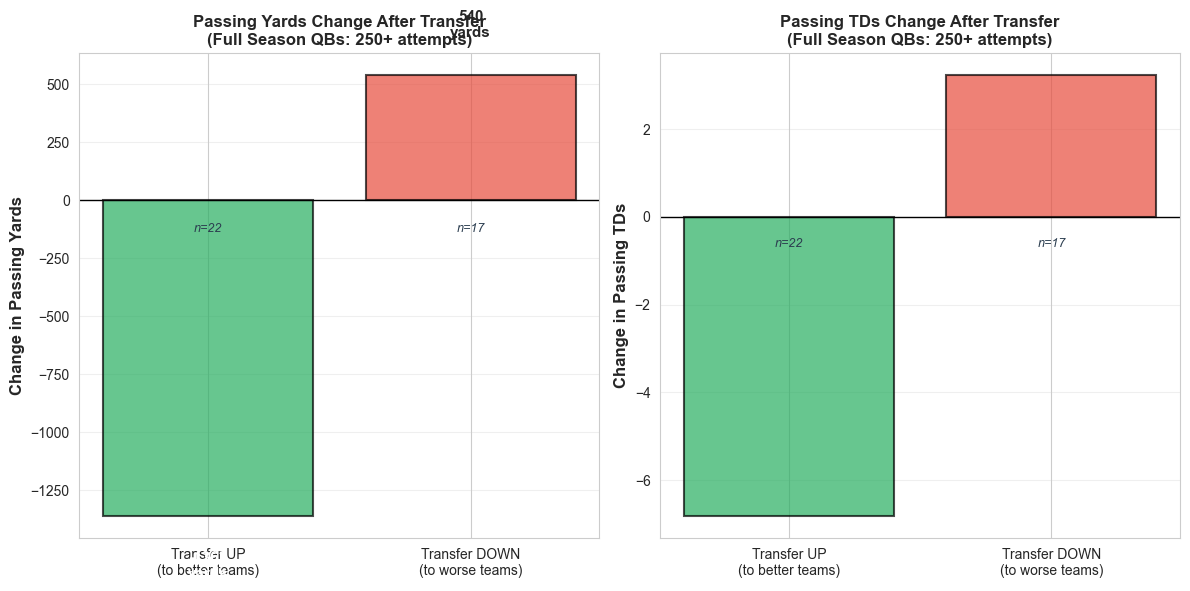


Key Finding: Volume stats decline regardless of transfer direction.
Transfer UP (n=22): -1363 yards, -6.8 TDs
Transfer DOWN (n=17): +540 yards, +3.2 TDs


In [ ]:
# Condensed version: Volume stat CHANGES by transfer direction (for infographic)
# Calculate changes for Transfer UP and DOWN
if len(volume_transfer_up) > 0 and len(volume_transfer_down) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Calculate changes
    yards_change_up = volume_transfer_up['after_pass_yds'].mean() - volume_transfer_up['before_pass_yds'].mean()
    yards_change_down = volume_transfer_down['after_pass_yds'].mean() - volume_transfer_down['before_pass_yds'].mean()
    
    tds_change_up = volume_transfer_up['after_pass_tds'].mean() - volume_transfer_up['before_pass_tds'].mean()
    tds_change_down = volume_transfer_down['after_pass_tds'].mean() - volume_transfer_down['before_pass_tds'].mean()
    
    # LEFT: Passing Yards Change
    directions = ['Transfer UP\n(to better teams)', 'Transfer DOWN\n(to worse teams)']
    yards_changes = [yards_change_up, yards_change_down]
    colors_yards = ['#27ae60', '#e74c3c']  # Green for UP, Red for DOWN
    
    bars1 = axes[0].bar(directions, yards_changes, color=colors_yards, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[0].set_ylabel('Change in Passing Yards', fontsize=12, fontweight='bold')
    axes[0].set_title('Passing Yards Change After Transfer\n(Full Season QBs: 250+ attempts)', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val, direction in zip(bars1, yards_changes, ['UP', 'DOWN']):
        height = bar.get_height()
        if val < 0:
            axes[0].text(bar.get_x() + bar.get_width()/2., height - 150,
                        f'{val:.0f}\nyards',
                        ha='center', va='top', fontsize=11, fontweight='bold', color='white')
        else:
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 150,
                        f'{val:.0f}\nyards',
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # add sample sizes
    axes[0].text(0, min(yards_changes) * 0.1, f'n={len(volume_transfer_up)}', 
                ha='center', fontsize=9, style='italic', color='#2c3e50')
    axes[0].text(1, min(yards_changes) * 0.1, f'n={len(volume_transfer_down)}', 
                ha='center', fontsize=9, style='italic', color='#2c3e50')
    
    # RIGHT: Passing TDs Change
    tds_changes = [tds_change_up, tds_change_down]
    colors_tds = ['#27ae60', '#e74c3c']
    
    bars2 = axes[1].bar(directions, tds_changes, color=colors_tds, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1].set_ylabel('Change in Passing TDs', fontsize=12, fontweight='bold')
    axes[1].set_title('Passing TDs Change After Transfer\n(Full Season QBs: 250+ attempts)', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    """
    for bar, val in zip(bars2, tds_changes):
        height = bar.get_height()
        if val < 0:
            axes[1].text(bar.get_x() + bar.get_width()/2., height - 0.3,
                        f'{val:.1f}\nTDs',
                        ha='center', va='top', fontsize=11, fontweight='bold', color='white')
        else:
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.3,
                        f'{val:.1f}\nTDs',
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
    """
    # Add sample sizes
    axes[1].text(0, min(tds_changes) * 0.1, f'n={len(volume_transfer_up)}', 
                ha='center', fontsize=9, style='italic', color='#2c3e50')
    axes[1].text(1, min(tds_changes) * 0.1, f'n={len(volume_transfer_down)}', 
                ha='center', fontsize=9, style='italic', color='#2c3e50')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nKey Finding: Volume stats decline regardless of transfer direction.")
    print(f"Transfer UP (n={len(volume_transfer_up)}): {yards_change_up:+.0f} yards, {tds_change_up:+.1f} TDs")
    print(f"Transfer DOWN (n={len(volume_transfer_down)}): {yards_change_down:+.0f} yards, {tds_change_down:+.1f} TDs")
else:
    print("Insufficient data for Transfer UP/DOWN comparison.")

## Distribution Analysis

/var/folders/4z/hd4s19xs4hb8xy7pkxtdvxvr0000gp/T/ipykernel_68079/4294636995.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Before Transfer", "After Transfer"])


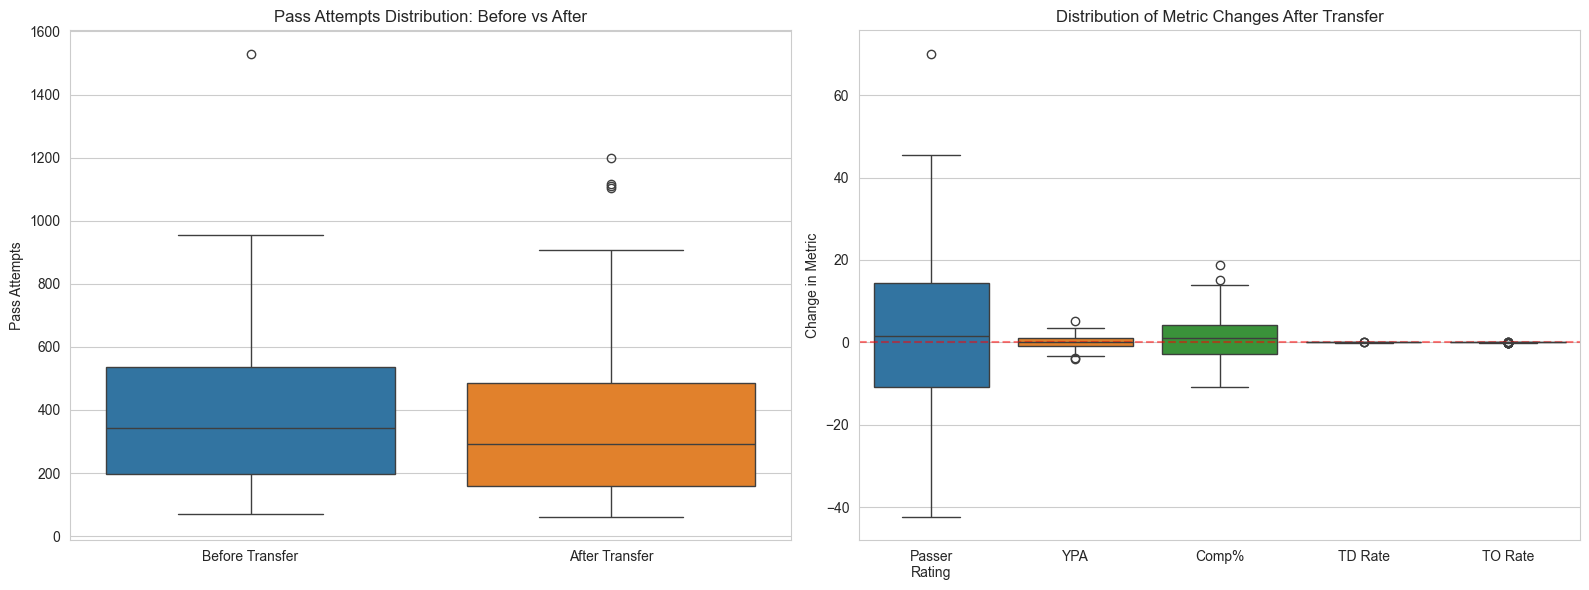

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=roi_df[["before_attempts", "after_attempts"]], ax=axes[0])
axes[0].set_ylabel("Pass Attempts")
axes[0].set_xticklabels(["Before Transfer", "After Transfer"])
axes[0].set_title("Pass Attempts Distribution: Before vs After")

metrics_to_plot = ["passer_rating_change", "ypa_change", "comp_pct_change", "td_rate_change", "to_rate_change"]
metric_labels = ["Passer\nRating", "YPA", "Comp%", "TD Rate", "TO Rate"]

plot_data = roi_df[metrics_to_plot].copy()
plot_data.columns = metric_labels

sns.boxplot(data=plot_data, ax=axes[1])
axes[1].axhline(y=0, color="red", linestyle="--", alpha=0.5)
axes[1].set_ylabel("Change in Metric")
axes[1].set_title("Distribution of Metric Changes After Transfer")

plt.tight_layout()
plt.show()

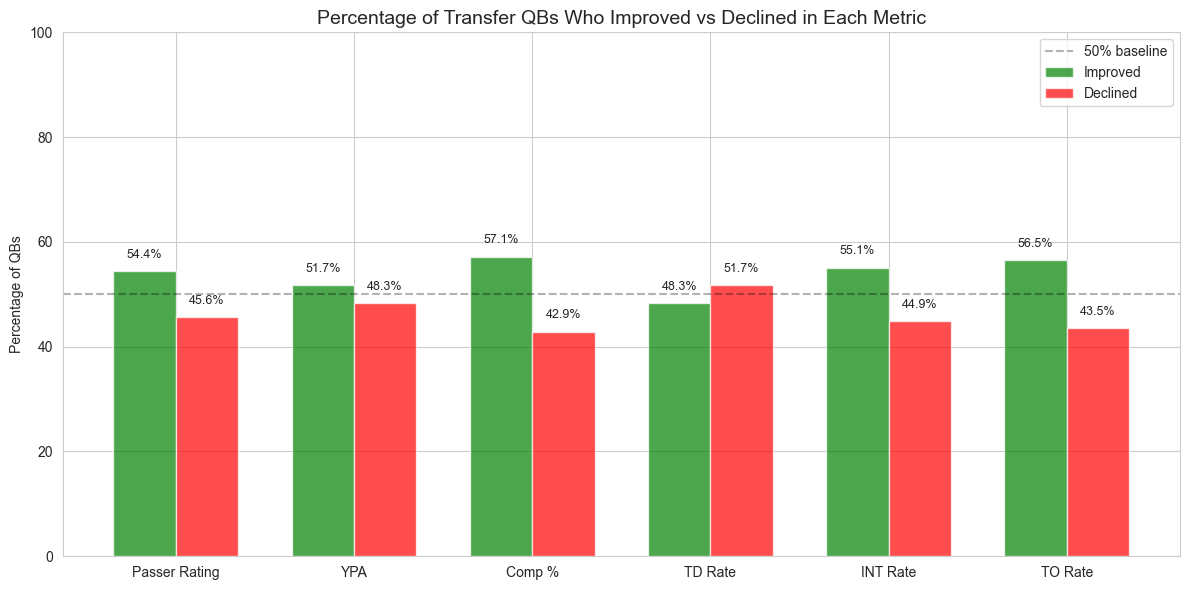

In [26]:
improvement_data = []

metrics = [
    ('Passer Rating', 'passer_rating_change', False),
    ('YPA', 'ypa_change', False),
    ('Comp %', 'comp_pct_change', False),
    ('TD Rate', 'td_rate_change', False),
    ('INT Rate', 'int_rate_change', True),
    ('TO Rate', 'to_rate_change', True),
]

for name, col, invert in metrics:
    if invert:
        improved = (roi_df[col] < 0).sum()
    else:
        improved = (roi_df[col] > 0).sum()
    
    declined = len(roi_df) - improved
    improvement_data.append({
        'Metric': name,
        'Improved': improved / len(roi_df) * 100,
        'Declined': declined / len(roi_df) * 100
    })

improvement_df = pd.DataFrame(improvement_data)

fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(improvement_df))
width = 0.35

ax.bar([i - width/2 for i in x], improvement_df['Improved'], width, label='Improved', color='green', alpha=0.7)
ax.bar([i + width/2 for i in x], improvement_df['Declined'], width, label='Declined', color='red', alpha=0.7)

ax.axhline(y=50, color='black', linestyle='--', alpha=0.3, label='50% baseline')
ax.set_ylabel('Percentage of QBs')
ax.set_title('Percentage of Transfer QBs Who Improved vs Declined in Each Metric', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(improvement_df['Metric'])
ax.legend()
ax.set_ylim(0, 100)

for i in x:
    ax.text(i - width/2, improvement_df.iloc[i]['Improved'] + 2, f"{improvement_df.iloc[i]['Improved']:.1f}%", 
            ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, improvement_df.iloc[i]['Declined'] + 2, f"{improvement_df.iloc[i]['Declined']:.1f}%", 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()